# imports and keys

In [14]:
# import os
# from dotenv import load_dotenv, find_dotenv
# env_path = find_dotenv()
# load_dotenv(env_path)
# GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
# GOOGLE_CX = os.getenv('GOOGLE_CX')

#from google_images_search import GoogleImagesSearch
#from google.cloud import vision

# FUNCTION text_detection_full_response

In [8]:
def text_detection_full_response(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    return response

# FUNCTION strip_menu

In [240]:
def strip_menu(response):
    
    # remove these chars from entry
    chars_to_remove = '0123456789!"\'#$%&()*+,-./:;<=>?@[\]^_`{|}~♦●★‒…£¡™¢∞§¶•ªº–≠≠œ∑´®†¥¨≤≥÷ç√€'

    # remove entry if it exactly matches any of these
    drop_exact_words = ['sandwiches','restaurant','menu',
                        'restaurant menu','thank you','drinks',
                        'appetizer','appetizers','mains','dessert',
                        'side','sides','side order','breakfast','lunch'
                       'dinner','supper','starter','starters','local',
                        'fresh','food','main','your','logo','brand name']
    
    # remove these words from entry
    words_to_remove = ['menu','restaurant','price','appetizer',
                       'appetizers','course','price','extra','extras']

    # remove entry if it contains any of these
    drop_contain_words = ['tax','consumer','advisory','illness','facebook','instagram']
    
    # remove entry if it starts with any of these
    drop_start_words = ['add','include','includes','including','lorem','with','and',
                       'served','serve']
    
    # drop entry if it contains fewer chars than minimum
    min_length = 4
    
    
    text = response.text_annotations[0].description
    menu_original = text.split('\n')
    
    menu_chars_removed = []
    for item in menu_original:
        for char in chars_to_remove:
            item = item.replace(char,' ')
        menu_chars_removed.append(item)
        
    menu_exact_matches_dropped = []
    for item in menu_chars_removed:
        if item.lower() in drop_exact_words:
            pass
        else:
            menu_exact_matches_dropped.append(item)
        
    menu_words_removed = []
    for item in menu_exact_matches_dropped:
        temporary = []
        for word in item.split(' '):
            if word.lower() not in words_to_remove:
                temporary.append(word)
        remaining_words = ' '.join(temporary)
        menu_words_removed.append(remaining_words)
             
    menu_contains_dropped = []
    for item in menu_words_removed:
        temporary = []
        for word in item.split(' '):
            if word.lower() in drop_contain_words:
                temporary = []
                pass
            else:
                temporary.append(word)
        remaining_words = ' '.join(temporary)
        menu_contains_dropped.append(remaining_words)

    menu_starts_dropped = []
    for item in menu_contains_dropped:
        temporary = item.split(' ')
        if temporary[0].lower() in drop_start_words:
            pass
        else:
            menu_starts_dropped.append(item)
    
    menu_exact_matches_dropped = []
    for item in menu_starts_dropped:
        if item.lower() in drop_exact_words:
            pass
        else:
            menu_exact_matches_dropped.append(item)
            
    bounding_white_space_removed = [item.strip() for item in menu_exact_matches_dropped]
    too_short_dropped = [item for item in bounding_white_space_removed if len(item) >= min_length]
    
    duplicates_dropped = []
    for item in too_short_dropped:
        if item not in duplicates_dropped:
            duplicates_dropped.append(item)

    
    stripped_menu = duplicates_dropped
   
    print(menu_original)
    print(stripped_menu)
    return(stripped_menu)

# FUNCTION optimized_image_fetch_and_check

In [3]:
def optimized_image_fetch_and_check(query):
    import os
    from dotenv import load_dotenv, find_dotenv
    from google_images_search import GoogleImagesSearch
    from google.cloud import vision

    env_path = find_dotenv()
    load_dotenv(env_path)
    
    GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
    GOOGLE_CX = os.getenv('GOOGLE_CX')
    
    print(f'searching for {query}...')
    print()

    gis = GoogleImagesSearch(GOOGLE_API_KEY,GOOGLE_CX)
    
    _search_params = {
    'q': f'{query} recipe',
    'num': 1,
    #'imgSize': 'large',
    'imgType': 'photo',
    'imgColorType': 'color'}
    
    gis.search(search_params=_search_params)
    print('fetching image:')
    if len(gis.results()) == 0:
        print('no image found, not verified as food.')
        print()
        return None
    
    url = gis.results()[0].url
    print(url)
    print()
    
    verified_queries = ['cheeseburger','burger','pizza','fried chicken','ice cream sundae','fuyung hai']
    
    if query.lower() in verified_queries:
        print(f'{query} already in known foods database, no need to verify!')
        print()
        return url
    
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = url
    
    response = client.label_detection(image=image, max_results=1)
    label = [lab.description for lab in response.label_annotations]
    score = [lab.score for lab in response.label_annotations]
    
    text_response = client.text_detection(image=image)
    texts = text_response.text_annotations
    n_chars = 0
    if len(texts)>0:
        n_chars = len(texts[0].description)
    
    print('verification filter:')
    print('label must be Food or Tableware')
    print('score must be above .96')
    print('number of chars must be below 100')
    print()
    print(f'label: {label}')
    print(f'label score: {score}')
    print(f'chars detected: {n_chars}')
    print()
    
    try:
        if (label[0] == 'Food' or label[0] == 'Tableware') and score[0] > .96 and n_chars < 100:
            print('verified as food!')
            print()
            print(url)
            print()
            return url
    except IndexError:
        print('label missing, not verified as food')
        pass
    

    _search_params = {
    'q': f'{query} recipe',
    'num': 3,
    #'imgSize': 'large',
    'imgType': 'photo',
    'imgColorType': 'color',
    'safe': 'medium'}
        
    gis = GoogleImagesSearch(GOOGLE_API_KEY,GOOGLE_CX)
    gis.search(search_params=_search_params)
    urls = [result.url for result in gis.results()]
    print('fetching additional images:')
    if len(urls)<=1:
        print('no additional images found, not verified as food')
        return None
    urls = urls[1:]
    for url in urls:
        print(url)
    print()
    
    labels = []
    scores = []
    char_counts = [] 
    for url in urls:
        
        image.source.image_uri = url
        response = client.label_detection(image=image, max_results=1)
        label = [lab.description for lab in response.label_annotations]
        score = [lab.score for lab in response.label_annotations]
        labels.append(label)
        scores.append(score)
        
        text_response = client.text_detection(image=image)
        texts = text_response.text_annotations
        n_chars = 0
        if len(texts)>0:
            n_chars = len(texts[0].description)
        char_counts.append(n_chars)
        
    print(f'labels: {labels}')
    print(f'label scores: {scores}')
    print(f'chars detected: {char_counts}')
    print()

    for label,score,n_chars in zip(labels,scores, char_counts):
        try:
            if (label[0] == 'Food' or label[0] == 'Tableware') and score[0] > .96 and n_chars < 100:
                print('verified as food!')
                print()
                print(urls[labels.index(label)])
                print()
                return urls[labels.index(label)]
        except:
            pass
        
    print('not verified as food.')
    print()
    return None


# FUNCTION detect_text_boxes

In [212]:
def detect_text_boxes(response):
    
    import pandas as pd
    
    texts = response.text_annotations

    text_list = []
    top_left = []
    top_right = []
    bottom_left = []
    bottom_right = []


    for text in texts[1:]:
        new_text = '''{}'''.format(text.description)
        text_list.append(new_text)
        
        vertices = [tuple((vertex.x, vertex.y)) for vertex in text.bounding_poly.vertices]

        new_bounding = vertices

        top_left.append(vertices[0])
        top_right.append(vertices[1])
        bottom_left.append(vertices[3])
        bottom_right.append(vertices[2])
        
    detected_df = pd.DataFrame({
        'text': text_list,
        'top_left': top_left,
        'top_right': top_right,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right
    })

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))


    return detected_df


#  FUNCTION text_show_cords

In [5]:
def text_show_cords(path):
    import io
    from google.cloud import vision
    from matplotlib import pyplot as plt
    from matplotlib import patches as pch
  
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image:
        content = image.read()
      
    image = vision.Image(content = content)
    response = client.text_detection(image = image)
    texts = response.text_annotations
    
    a = plt.imread(path)
    fig, ax = plt.subplots(1)
    ax.imshow(a)
    
    for text in texts:
        #print(text.description)
      
        vertices = ([(vertex.x, vertex.y) 
                 for vertex in text.bounding_poly.vertices]) 
    
        #print('Vertices covering text: {}\n\n'.format(vertices))
        rect = pch.Rectangle(vertices[0], (vertices[1][0] - vertices[0][0]), 
                        (vertices[2][1] - vertices[0][1]), linewidth = 1, 
                                       edgecolor ='r', facecolor ='none') 
        ax.add_patch(rect)
    

# paths to menus

In [10]:
path_start = '../raw_data/all_menus/'

files = ['warung_sika_food.jpg',
'chinese_menu_1.png',
'english_menu_1.png',
'english_menu_2.jpg',
'english_menu_3.jpg',
'english_menu_4.jpg',
'english_menu_5.jpg',
'english_menu_6.jpg',
'english_menu_7.png',
'english_menu_8.png',
'english_menu_9.jpg',
'english_menu_10.jpg',
'english_menu_11.jpg',
'english_menu_12.png',
'indo_menu_1.png',
'saudi_menu_1.jpeg',
'spanish_menu_1.jpg',
'spanish_menu_2.jpg',
'thai_menu_1.png',
'warung_sika_drinks.jpg']

paths = [path_start + file for file in files]

# text-detected menus 

In [ ]:
# detected_menus = []
# for path in paths:
#     detected_menus.append(text_detection_full_response(path))

#  show menu

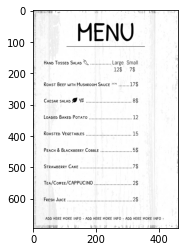

In [251]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread(paths[11])
plt.imshow(img)


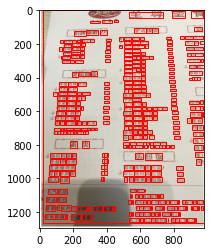

In [186]:
text_show_cords(paths[1])

# sandbox

In [187]:
test_menu = text_detection_full_response(paths[1])

In [211]:
test_menu_df = detect_text_boxes(test_menu)
test_menu_df

,text,top_left,top_right,bottom_left,bottom_right
0,休闲,"(303, 61)","(360, 58)","(304, 80)","(361, 77)"
1,至尊,"(374, 58)","(429, 55)","(375, 76)","(430, 73)"
2,堡,"(441, 54)","(466, 53)","(442, 72)","(467, 71)"
3,招牌,"(204, 120)","(275, 118)","(205, 152)","(276, 150)"
4,咖喱,"(278, 118)","(346, 116)","(279, 149)","(347, 147)"
...,...,...,...,...,...
403,限,"(785, 1237)","(804, 1237)","(785, 1260)","(804, 1260)"
404,两,"(807, 1237)","(828, 1237)","(807, 1260)","(828, 1260)"
405,公里,"(830, 1237)","(874, 1237)","(830, 1261)","(874, 1261)"
406,以内,"(879, 1238)","(920, 1238)","(879, 1261)","(920, 1261)"


In [189]:
stripped_test_menu = strip_menu(test_menu)


['休闲至尊堡', '招牌咖喱 力', '♦咖喱鸡扒/猪扒饭', '咖喱牛肉饭', '●咖喱牛腩饭', '咖喱肥牛饭', "'咖喱海鲜饭", '咖喱滑鸡饭', '榨菜肉丝汤面', '鲜虾云吞', '●番茄肥牛汤河粉', '香辣牛肉面方', '雪菜肉丝面', '咖喱海鲜面丿', '酱香牛腩面', '鲜虾云吞面', '肠仔/火腿/烟肉煎蛋', '以上可配米粉/河粉/公仔面/意粉', '改乌冬面/车仔面加收3元', '粥类', '瑶柱鸡皇粥', '冬菇滑鸡粥', '皮蛋瘦肉粥', '窝蛋牛肉粥', '明火白粥', '人气出品', '新品推出', '需要时长约25分钟,敬请留意!', '带有辛辣,敬请留意!', '烫粉面类', '28', '35', '35', '30', '32', '30', '18', '23', '20', '20', '15', '20', '23', '23', '18', '15', '13', '13', '15', 'LO', '5', '5335', '至尊空食', '中式饭类', '意', '★台式卤肉饭', '25', '●经典意大利', '至尊鲍鱼鸡饭', '32', '米兰辣i', '★ 葡式咸猪手饭', '28', '三杯鸡饭', '28', '咖喱海鲜', '水煮肥牛饭', '32', '鲜茄牛柳', '白果支竹猪肚饭', '28', '26', '卡邦尼灯', '金菇肥牛饭', '番茄牛肉饭', '法式鸡皇饭', '28', '忌廉蛋汁', '25', '20', '拿破仑', '鱼香茄子饭', '韭黄滑蛋饭', '23', '加5元热', '虾仁滑蛋饭', '28', '叉烧滑蛋饭', '23', '生炒排骨饭', '28', '姜葱白切鸡饭', '30', '手撕鸡饭', '30', '蜜汁叉烧饭', '26', '腊味煲', '香草茄汁鸡扒/鸡扒饭 30', '豉汁拌', '鲜菇牛肉/排骨饭', '30', '榨菜片', '凉瓜牛肉/肉片饭', '25', '萝卜牛腩饭', '●黑椒', '32', '支竹牛腩饭', '32', '榄菜', '酱爆猪颈肉饭', '25', '冬菇', '麻婆豆腐饭 炒', '23', '鱼干', '以上出品送老火汤+5元配炖汤', '加5元送热饮1杯,加7元送冻饮1杯', '咸鱼',

In [241]:
def get_url_dict(stripped_menu):
    url_dict = {}
    for menu_item in stripped_menu:
        url = optimized_image_fetch_and_check(menu_item)
        if url is not None:
            url_dict[menu_item] = url
    return url_dict

In [191]:
url_dict

{'休闲至尊堡': 'https://gw.alicdn.com/imgextra/i4/2206810018412/O1CN01IRW2Zb2C0kKdLtnFE_!!2206810018412.jpg_Q75.jpg_.webp',
 '招牌咖喱 力': 'https://pic2.zhimg.com/v2-fd2d14767712268d5b05e83515116371_b.jpg',
 '咖喱鸡扒 猪扒饭': 'https://3.bp.blogspot.com/-izAZXdPka2Y/WKRG-KhxZSI/AAAAAAAAa9w/YkHlW7zPVTwq2XxuRP9HrfA9BdaQCrYGACLcB/s1600/Baked%2BPork%2BChop%2BRice.jpg',
 '咖喱牛肉饭': 'https://i8.meishichina.com/attachment/recipe/2014/02/19/20140219155014171271785.jpg?x-oss-process=style/p800',
 '咖喱牛腩饭': 'https://i.ytimg.com/vi/ysKCfYPJ-gk/maxresdefault.jpg',
 '咖喱肥牛饭': 'https://i2.chuimg.com/c8b5e94609b1478099fae82c8ebb9d21_2048w_2048h.jpg?imageView2/2/w/660/interlace/1/q/90',
 '咖喱滑鸡饭': 'https://i.ytimg.com/vi/Ve6nusIGj2w/maxresdefault.jpg',
 '榨菜肉丝汤面': 'https://i.ytimg.com/vi/-kn2-ERwv9M/maxresdefault.jpg',
 '鲜虾云吞': 'https://i.pinimg.com/736x/af/78/13/af781324b7c4388589d4231762e53c5a.jpg',
 '番茄肥牛汤河粉': 'https://i2.chuimg.com/ccd10fc0878b11e6b87c0242ac110003_600w_401h.jpg?imageView2/2/w/660/interlace/1/q/90',
 '香

In [192]:
test_menu_df.head()

,text,top_left,top_right,bottom_left,bottom_right
0,休闲,"(303, 61)","(360, 58)","(304, 80)","(361, 77)"
1,至尊,"(374, 58)","(429, 55)","(375, 76)","(430, 73)"
2,堡,"(441, 54)","(466, 53)","(442, 72)","(467, 71)"
3,招牌,"(204, 120)","(275, 118)","(205, 152)","(276, 150)"
4,咖喱,"(278, 118)","(346, 116)","(279, 149)","(347, 147)"


In [233]:
def map_text_boxes(detected_df, url_dict):
    from itertools import combinations
    import pandas as pd
    from statistics import stdev
    import string

    test_menu_df = detected_df

    split_keys = []
    for key in url_dict.keys():
        split_keys.append(key.split())

    temp_dfs = []
    for key_set in split_keys:
        temp_df = pd.DataFrame()
        for key in key_set:
            mask = test_menu_df['text'] == key
            temp_df = pd.concat([temp_df, test_menu_df[mask]])
            temp_df = temp_df.drop_duplicates()
        temp_df['position'] = temp_df['bottom_left'] 

        word_positions = list(zip(temp_df.text, temp_df.position))
        combos = []

        for combo in list(combinations(word_positions, len(key_set))): 
            text_portion = [pair[0] for pair in combo]
            if len(set(text_portion)) == len(key_set):
                combos.append(combo)
        calc_df = pd.DataFrame(combos)

        position_stds = []
        for combo in combos:
            position = [pair[1] for pair in combo]
            if len(position) >= 2:
                calc_nums = [pair[1] for pair in position]
                position_stds.append(stdev(calc_nums))
            else:
                position_stds.append(0)
        calc_df['position_stds'] = position_stds
        calc_df = calc_df.sort_values(by=['position_stds'])

        if len(calc_df) > 0:
            calc_df = calc_df.iloc[[0]]

        keep = []
        keep_text = []
        keep_pos = []
        for column in calc_df:
            if column != 'position_stds':
                keep.append(calc_df[column].to_string(index=False))
        for item in keep:
            pair = item.split(', ')
            temp_text = [char for char in pair[0] if char not in '[](),']
            temp_pos = [char for char in pair[1:]]
            temp_pos = str(temp_pos)
            temp_pos = [char for char in temp_pos if char in string.digits or char not in string.punctuation]
            temp_text = ''.join(temp_text)
            temp_pos = ''.join(temp_pos)
            temp_pos = temp_pos.split(' ')
            temp_pos = [int(n) for n in temp_pos]
            temp_pos = tuple(temp_pos)

            keep_text.append(''.join(temp_text))
            keep_pos.append(temp_pos)

        merge_df = pd.DataFrame()
        for text,pos in zip(keep_text,keep_pos):
            merge_df = pd.concat([merge_df, pd.DataFrame({'text': [text],
                                    'top_left': [None],
                                    'top_right': [None],
                                    'bottom_left': [None],
                                    'bottom_right': [None],
                                    'position': [pos]})], ignore_index=False)
        temp_df = pd.concat([temp_df,merge_df],ignore_index=False)
        if None in temp_df['top_left'].values:
            temp_df = temp_df.loc[temp_df.duplicated(subset='position', keep=False)]
        temp_df = temp_df.dropna()

        for index in temp_df.index:
            if index in test_menu_df.index:
                test_menu_df = test_menu_df.drop(index)
        temp_dfs.append(temp_df)
        
    box_dict = {}

    for i, key in enumerate(url_dict.keys()):
        try:
            box_dict[key] = [temp_dfs[i].iloc[0]['top_left'],
                     temp_dfs[i].iloc[-1]['bottom_right']]
        except IndexError:
            pass
        
    return box_dict

In [208]:
box_dict = {}

for i, key in enumerate(url_dict.keys()):
    try:
        box_dict[key] = [temp_dfs[i].iloc[0]['top_left'],
                     temp_dfs[i].iloc[-1]['bottom_right']]
    except IndexError:
        pass
                     
print(box_dict)

{'休闲至尊堡': [(441, 54), (467, 71)], '招牌咖喱 力': [(362, 115), (402, 145)], '咖喱鸡扒 猪扒饭': [(195, 174), (589, 1222)], '咖喱牛肉饭': [(252, 657), (637, 738)], '咖喱滑鸡饭': [(183, 292), (153, 913)], '榨菜肉丝汤面': [(939, 683), (219, 736)], '鲜虾云吞': [(875, 253), (901, 274)], '番茄肥牛汤河粉': [(900, 252), (344, 713)], '香辣牛肉面方': [(917, 183), (273, 534)], '咖喱海鲜面丿': [(247, 568), (256, 591)], '肠仔 火腿 烟肉煎蛋': [(91, 659), (660, 1020)], '以上可配米粉 河粉 公仔面 意粉': [(125, 698), (968, 125)], '改乌冬面 车仔面加收 元': [(84, 719), (615, 1259)], '瑶柱鸡皇粥': [(159, 851), (211, 985)], '窝蛋牛肉粥': [(55, 956), (85, 985)]}


In [243]:
def show_text_boxes(path, box_dict):
    import io
    from matplotlib import pyplot as plt
    from matplotlib import patches as pch
    
    
    a = plt.imread(path)
    fig, ax = plt.subplots(1)
    ax.imshow(a)
    
    for value in box_dict.values():
        rect = pch.Rectangle(value[0], 
                            abs(value[0][0]-value[-1][0]), abs(value[0][1]-value[-1][1]), 
                            linewidth = 1, edgecolor ='r', facecolor ='none') 
        ax.add_patch(rect)
    

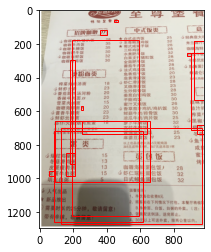

In [210]:
menu_show_boxes(paths[1])

['SALLngl', 'MENU', 'HAND TOSSED SALAD Large Small', '12$ 7$', 'ROAST BEEF WITH MUSHROOM SAUCE O', '.17$', 'CAESAR SALAD', 'LOW', 'Fat', '8$', 'LOADED BAKED POTATO', '12', 'ROASTED VEGETABLES', '15', 'PEACH & BLACKBERRY COBBLE', '.5$', 'STRAWBERRY CAKE', '.7$', 'TEA/COFFEE/CAPPUCINO', '2$', 'FRESH JUICE', '.2$', 'ADD HERE MORE INFO ADD HERE MORE INFO ADD HERE MORE INFO.']
['SALLngl', 'HAND TOSSED SALAD Large Small', 'ROAST BEEF WITH MUSHROOM SAUCE O', 'CAESAR SALAD', 'LOADED BAKED POTATO', 'ROASTED VEGETABLES', 'PEACH   BLACKBERRY COBBLE', 'STRAWBERRY CAKE', 'TEA COFFEE CAPPUCINO', 'FRESH JUICE']
searching for SALLngl...

fetching image:
no image found, not verified as food.

searching for HAND TOSSED SALAD Large Small...

fetching image:
https://www.spendwithpennies.com/wp-content/uploads/2019/04/Tossed-Salad-SWP-4.jpg

verification filter:
label must be Food or Tableware
score must be above .96
number of chars must be below 100

label: []
label score: []
chars detected: 0

label miss

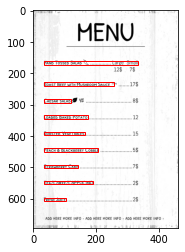

In [252]:
response = text_detection_full_response(paths[11])
stripped_menu = strip_menu(response)
detected_df = detect_text_boxes(response)
url_dict = get_url_dict(stripped_menu)
print(url_dict)
box_dict = map_text_boxes(detected_df, url_dict)
print(box_dict)
show_text_boxes(paths[11], box_dict)

In [611]:
sample_df = detect_text_boxes(test_menu)
sample_df['height'] = abs(sample_df['top_left'].str[1] - sample_df['bottom_left'].str[1])

In [612]:
sample_df['line_cord'] = sample_df['bottom_left'].str[1]

In [613]:
sample_df = sample_df.sort_values(by='line_cord')

In [614]:
sample_df

,text,bounding_all,top_left,top_right,bottom_left,bottom_right,height,line_cord
73,Menu,"[(319, 6), (434, 7), (433, 56), (318, 55)]","(319, 6)","(434, 7)","(318, 55)","(433, 56)",49,55
74,Main,"[(302, 178), (375, 177), (375, 207), (303, 208)]","(302, 178)","(375, 177)","(303, 208)","(375, 207)",30,208
159,8.50,"[(415, 248), (438, 248), (438, 256), (415, 256)]","(415, 248)","(438, 248)","(415, 256)","(438, 256)",8,256
76,MIXTA,"[(287, 246), (327, 246), (327, 256), (287, 256)]","(287, 246)","(327, 246)","(287, 256)","(327, 256)",10,256
75,PAELLA,"[(236, 246), (283, 246), (283, 257), (236, 257)]","(236, 246)","(283, 246)","(236, 257)","(283, 257)",11,257
...,...,...,...,...,...,...,...,...
158,.,"[(349, 648), (353, 648), (353, 658), (349, 658)]","(349, 648)","(353, 648)","(349, 658)","(353, 658)",10,658
67,.,"[(95, 649), (100, 649), (100, 659), (95, 659)]","(95, 649)","(100, 649)","(95, 659)","(100, 659)",10,659
66,tellus,"[(70, 649), (95, 649), (95, 659), (70, 659)]","(70, 649)","(95, 649)","(70, 659)","(95, 659)",10,659
65,in,"[(60, 649), (67, 649), (67, 659), (60, 659)]","(60, 649)","(67, 649)","(60, 659)","(67, 659)",10,659


In [615]:
import pandas as pd

all_lines = []
avg_heights = []
line_cords = []
for n in sample_df['line_cord'].unique():
    same_line_df = sample_df[sample_df['line_cord']==n] 
    same_line = []
    heights = []
    for text,height in zip(same_line_df['text'],same_line_df['height']):
        same_line.append(text)
        heights.append(height)
    all_lines.append(' '.join(same_line))
    avg_height = int(sum(heights)/len(heights))
    avg_heights.append(avg_height)
    line_cords.append(n)


In [616]:
strict_combine_df = pd.DataFrame({'text': all_lines, 'avg_height': avg_heights, 'line_cords': line_cords})
strict_combine_df.sort_values(by='avg_height')

,text,avg_height,line_cords
25,8.00,8,476
16,12.00,8,403
2,8.50 MIXTA,9,256
40,11.50,9,623
38,. eu complectitur recusabo,9,584
48,. tellus in maximus,10,659
47,recusabo complectitur eu .,10,658
20,", sit ipsum dolor sit amet audire",10,423
29,Pellentesque nec nulla non urna,10,497
30,"Lorem ipsum dolor sit amet sit audire ,",10,498


In [617]:
temp_df = strict_combine_df
temp_df['soft_line_cords'] = temp_df['line_cords']//7

all_lines = []
soft_avg_heights = []
line_cords = []
for n in temp_df['soft_line_cords'].unique():
    same_line_df = temp_df[temp_df['soft_line_cords']==n] 
    same_line = []
    heights = []
    for text,height in zip(same_line_df['text'],same_line_df['avg_height']):
        same_line.append(text)
        heights.append(height)
    soft_avg_height = int((sum(heights)/len(heights))//2)
    all_lines.append(' '.join(same_line))
    soft_avg_heights.append(soft_avg_height)
    line_cords.append(n)

In [618]:
soft_combine_df = pd.DataFrame({'text': all_lines, 'soft_avg_height': soft_avg_heights, 'soft_line_cords': line_cords})
soft_combine_df.sort_values(by='soft_avg_height')


,text,soft_avg_height,soft_line_cords
19,. eu complectitur recusabo recusabo complectit...,4,83
11,", sit ipsum dolor sit amet audire Lorem Lorem ...",5,60
18,"Lorem , ipsum audire sit sit amet dolor Lorem ...",5,81
16,7.00,5,78
15,. faucibus maximus in tellus complectitur . eu...,5,73
14,Pellentesque nec nulla non urna Lorem ipsum do...,5,71
13,8.00 AL POLLO HORNO 6.00 PATATAS BRAVAS,5,68
12,complectitur . eu complectitur recusabo recusa...,5,62
21,"audire sit , amet dolor sit ipsum Lorem faucib...",5,92
10,ESCALIVADA,5,58


In [26]:
response = text_detection_full_response(paths[2])
= detect_text_boxes(response)

text_annotations {
  locale: "en"
  description: "Restaurant Menu\nSandwiches\nHamburger.......\n..$2.50\n\342\200\222\342\200\222\342\200\222\342\200\222\342\200\222\342\200\222\342\200\222\342\200\222\nCheeseburger............\n.$3.00\nChicken burger.\n....$3.50\nFried chicken...........\n..$4.00\nSubway\n..$4.50\nPizza..........\n............$5.00\nPotato chips......\n.$1.50\nFrench fries........\n$2.50\nSalad.\n........$3.00\nDrinks\nCoca Cola...........\n..$2.00\n7Up.................\n.$2.00\nPepsi Cola..............\n..$2.00\nMountain Dew\n..$2.00\nRed Bull...........\n..$3.00\nStarbucks coffee..........\n.$4.00\nDessert\nBaskin Robbins Sundae..........$2.50\n\342\200\246\342\200\246\342\200\246\342\200\246\342\200\246\342\200\246\342\200\246\nKFC\nCoca-Cola Cola\n09/"
  bounding_poly {
    vertices {
      x: 55
      y: 41
    }
    vertices {
      x: 548
      y: 41
    }
    vertices {
      x: 548
      y: 772
    }
    vertices {
      x: 55
      y: 772
    }
  }
}
text_a

In [23]:
test_menu_indo = [
    "BANDREK",
    "KOLTEH TELUR"]

In [36]:
for item in test_menu_indo:
    optimized_image_fetch_and_check(item)

searching for BANDREK...

fetching image:
https://378001-1184276-1-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2021/02/bandrek2.jpg

verification filter:
label must be Food or Tableware
score must be above .96
number of chars must be below 100

label: ['Food']
label score: [0.9650222659111023]
chars detected: 0

verified as food!

https://378001-1184276-1-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2021/02/bandrek2.jpg

searching for KOLTEH TELUR...

fetching image:
https://w7.pngwing.com/pngs/481/231/png-transparent-indian-cuisine-fennel-spice-herb-annatto-cauliflower-longjing-tea-vegetables-indian-cuisine.png

verification filter:
label must be Food or Tableware
score must be above .96
number of chars must be below 100

label: ['Plant']
label score: [0.963361382484436]
chars detected: 0

fetching additional images:
https://sribu-sg.s3.amazonaws.com/assets/media/contest_detail/2020/9/kontes-desain-brosur-untuk-warung-siomay-quot-siomay-patuo-quot-5f54b98efaaa2678